### 問題１

このコンペの評価指標はAUCと呼ばれるROC曲線の面積になります。ここでは復習も兼ねて、以下の点を意識しながら調査し、notebookに記述

#### なぜ閾値が存在するのか？

閾値は決定境界と同値だと考えられる.判定は決定境界によって決まり、偽陽性率も真陽性率も決定境界によって決まる.そのため閾値がなければROC曲線自体導けなくなる

#### ROC曲線の縦軸と横軸は何を意味するか？

ROCの横軸が偽陽性率で縦軸は真陽性率

#### ROC曲線はどのような形状が理想的だと言えるか？

ROC曲線は良い程左上にシフトすることがしられており,最も良い場合(x,y)=(0,1)(1,1)を通るAUC面積が1.0の曲線.

#### MCC（マシューズ相関係数）とF1スコア

2値分類において多数クラスが正の場合accuracy,recall,precision,F1すべて正当に評価できなくなる
そこでMCCを導入する.MCCの定義は((TP x TN) - (FP x FN)) / sqrt((TP + FP) x (TP + FN) x (TN + FP) x (TN + FN))
マシューズ相関係数は-1と+1の間の値を取り、予測と実測が完璧にマッチすると+1、予測と実測が完全に不一致では-1、ランダムな予測と同等ですと0となる
F1スコアとの違いはF1スコアは正負のクラスの定義に影響される(少数クラスが正の場合正しいが、多数クラスが正の時に誤る)がMCCはどちらも同じように評価できる
参考https://blog.datarobot.com/jp/matthews-correlation-coefficient

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
#import xgboost as xgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import roc_auc_score
import gc
from sklearn.model_selection import train_test_split
gc.enable()
%matplotlib inline
plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

# dataが重いのでtypeを変更する
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [2]:
# dataのダウンロード 
print('Download Train and Test Data.\n')
train = pd.read_csv('train.csv', dtype=dtypes, low_memory=True)
train['MachineIdentifier'] = train.index.astype('uint32')
test  = pd.read_csv('test.csv',  dtype=dtypes, low_memory=True)
test['MachineIdentifier']  = test.index.astype('uint32')
gc.collect()

Download Train and Test Data.



201096

In [3]:
# dataを絞る1%に
train_small = train.sample((90000))

In [4]:
train_small.describe()

,MachineIdentifier,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,9.000000e+04,90000.000000,89691.0,90000.000000,4443.000000,89643.000000,89643.0,89643.0,90000.000000,90000.000000,86684.000000,6.206000e+04,89997.0,90000.000000,90000.000000,90000.00000,89643.0,90000.000000,84480.000000,89393.0,89064.0,89894.000000,89069.0,89015.000000,89591.0,89591.0,89591.0,8.947900e+04,8.947900e+04,90000.000000,89231.000000,89527.000000,89528.0,89528.0,8.718500e+04,90000.000000,90000.000000,89358.0,90000.000000,90000.000000,15420.000000,88315.0,33086.000000,88151.0,88396.000000,90000.000000,33174.0,89819.000000,90000.000000,90000.000000,89266.000000,86926.000000,86926.0,90000.000000
mean,4.451326e+06,0.000011,NaN,0.017267,inf,47937.121094,NaN,NaN,0.988000,107.663767,81081.757812,inf,NaN,28.075233,15714.401889,575.57890,NaN,0.000033,0.000485,NaN,NaN,0.995061,NaN,239177.359375,NaN,NaN,NaN,5.142215e+05,3.789677e+05,0.076922,6115.913086,NaN,NaN,NaN,1.118953e+09,15827.920289,968.999867,NaN,60.111689,0.000467,0.000065,0.0,0.000272,NaN,32955.359375,0.487000,0.0,0.007404,0.126467,0.038600,0.057770,0.280762,NaN,0.500178
std,2.578768e+06,0.003333,0.0,0.130264,inf,13951.301758,0.0,0.0,0.108886,62.938332,48996.273438,5.625000e+00,NaN,65.530523,2198.203322,247.99289,0.0,0.005773,0.022018,NaN,0.0,0.237063,NaN,72141.265625,0.0,0.0,NaN,3.672247e+05,3.341591e+05,0.266469,5449.838379,0.000000,NaN,NaN,1.886106e+09,1969.051475,2918.100106,0.0,44.805159,0.021598,0.008057,0.0,0.016479,NaN,21178.902344,0.499834,0.0,0.085693,0.332376,0.192641,0.233521,0.449707,0.0,0.500003
min,4.520000e+02,0.000000,0.0,0.000000,10.000000,16.000000,1.0,0.0,0.000000,1.000000,34.000000,1.000000e+00,1.0,-127.000000,7600.000000,16.00000,0.0,0.000000,0.000000,1.0,0.0,0.000000,74.0,23.000000,1.0,1.0,19.0,1.024000e+04,9.689000e+03,0.000000,512.000000,4.898438,-1.0,-1.0,0.000000e+00,10240.000000,0.000000,1.0,5.000000,0.000000,0.000000,0.0,0.000000,37.0,33.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,2.217005e+06,0.000000,7.0,0.000000,788.000000,49480.000000,1.0,1.0,1.000000,51.000000,36825.000000,1.800000e+01,89.0,-29.000000,15063.000000,256.00000,1.0,0.000000,0.000000,111.0,1.0,1.000000,1443.0,189744.500000,2.0,5.0,1998.0,2.393720e+05,1.207850e+05,0.000000,4096.000000,13.898438,1366.0,768.0,0.000000e+00,15063.000000,167.000000,8.0,31.000000,0.000000,0.000000,0.0,0.000000,142.0,13156.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0.000000
50%,4.450694e+06,0.000000,7.0,0.000000,1632.000000,53447.000000,1.0,1.0,1.000000,97.000000,82373.000000,2.700000e+01,181.0,58.000000,16299.000000,768.00000,1.0,0.000000,0.000000,117.0,1.0,1.000000,2102.0,246715.000000,4.0,5.0,2500.0,4.769400e+05,2.495530e+05,0.000000,4096.000000,15.500000,1366.0,

## 問題2 EDA

仮説
FireWallのあるなし、Hastpm のあるなし、Isprotectedのあるなし、IsBetaのあるなしがセキュリティ的に関係ありそう

Text(0.5, 1.0, 'HasDetections(target)')

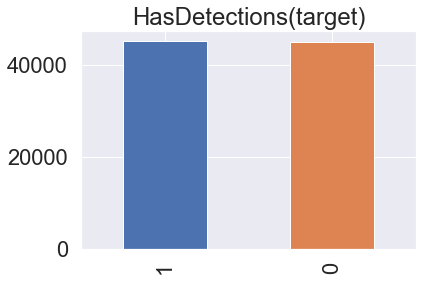

In [5]:
# check the EDA
train_small['HasDetections'].value_counts().plot.bar()
plt.title('HasDetections(target)')

In [6]:
# checking missing data
total = train_small.isnull().sum().sort_values(ascending = False)
percent = (train_small.isnull().sum()/train_small.isnull().count()*100).sort_values(ascending = False)
missing_train_small_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [9]:
# 欠損値を確認する
missing_train_small_data.head(20)

,Total,Percent
PuaMode,89975,99.972222
Census_ProcessorClass,89618,99.575556
DefaultBrowsersIdentifier,85557,95.063333
Census_IsFlightingInternal,74580,82.866667
Census_InternalBatteryType,63831,70.923333
Census_ThresholdOptIn,56914,63.237778
Census_IsWIMBootEnabled,56826,63.140000
SmartScreen,32005,35.561111
OrganizationIdentifier,27940,31.044444
SMode,5520,6.133333


In [10]:
# OS.ver
train['Census_OSVersion']

0            10.0.17134.165
1              10.0.17134.1
2            10.0.17134.165
3            10.0.17134.228
4            10.0.17134.191
5            10.0.17134.165
6            10.0.17134.165
7              10.0.14393.0
8            10.0.17134.254
9            10.0.16299.431
10           10.0.17134.167
11           10.0.17134.228
12           10.0.17134.191
13           10.0.17134.228
14           10.0.17134.191
15           10.0.17134.228
16           10.0.10586.164
17           10.0.17134.191
18           10.0.17134.285
19           10.0.16299.309
20             10.0.14393.0
21         10.0.10240.17914
22           10.0.17134.228
23           10.0.17134.228
24           10.0.17134.137
25           10.0.16299.125
26           10.0.17134.191
27           10.0.17134.112
28           10.0.17134.228
29            10.0.16299.15
                 ...       
8921453      10.0.17134.285
8921454      10.0.17134.254
8921455     10.0.14393.1480
8921456      10.0.17134.165
8921457        10.0.

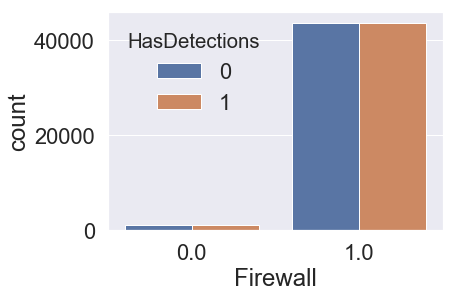

In [11]:
# FireWallのあるなし
sns.countplot(x='Firewall', hue='HasDetections',data=train_small)
plt.show()

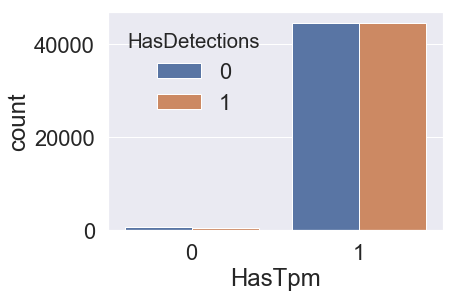

In [12]:
# Hastpm のあるなし
sns.countplot(x='HasTpm', hue='HasDetections',data=train_small)
plt.show()

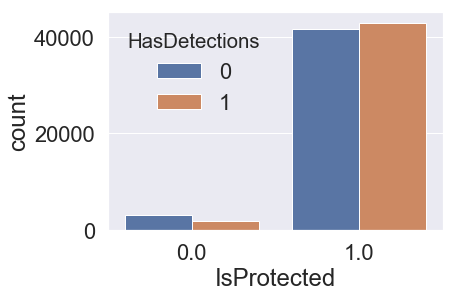

In [13]:
# Isprotectedのあるなし
sns.countplot(x='IsProtected', hue='HasDetections',data=train_small)
plt.show()

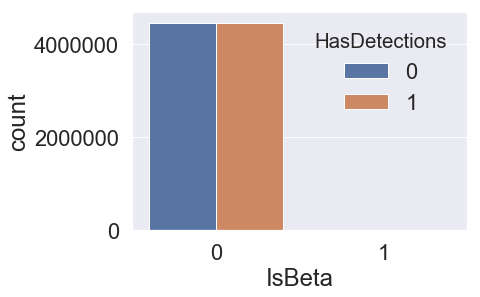

In [13]:
# IsBeta
sns.countplot(x='IsBeta', hue='HasDetections',data=train_small)
plt.show()

これまでのデータは偏りすぎて参考にならない。基本的に明らかなセキュリティが低いパターンはなさそう

続いてユーザー側の特徴量を確認
SmartScreen, IsGamerに着目する

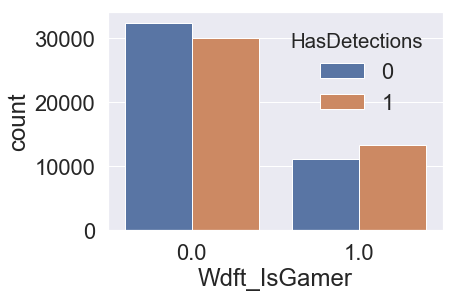

In [14]:
# IsGamer
sns.countplot(x='Wdft_IsGamer', hue='HasDetections',data=train_small)

In [15]:
def plot_category_percent_of_target(col):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    cat_percent = train_small[[col, 'HasDetections']].groupby(col, as_index=False).mean()
    cat_size = train_small[col].value_counts().reset_index(drop=False)
    cat_size.columns = [col, 'count']
    cat_percent = cat_percent.merge(cat_size, on=col, how='left')
    cat_percent['HasDetections'] = cat_percent['HasDetections'].fillna(0)
    cat_percent = cat_percent.sort_values(by='count', ascending=False)[:20]
    sns.barplot(ax=ax, x='HasDetections', y=col, data=cat_percent, order=cat_percent[col])

    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_percent['count'].values[i]), (p.get_width(), p.get_y()+0.5), fontsize=20)

    plt.xlabel('% of HasDetections(target)')
    plt.ylabel(col)
    plt.show()


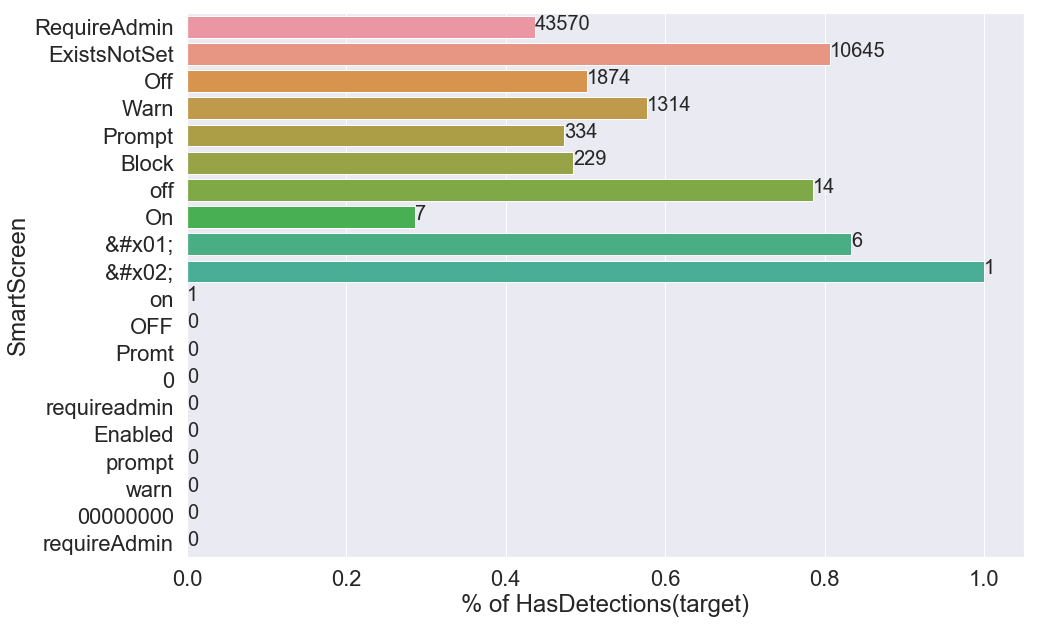

In [16]:
col = 'SmartScreen'
plot_category_percent_of_target(col)

Gamerの方が感染率が高いとわかる

dataが多いところでRequreAdminとExistsNotSetではExistsNotSetが倍くらい高い
設定が重要とわかる

In [17]:
#trainデータの各特徴量の欠損比率を確認する。
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [18]:
missing_train_data.head(10)

,Total,Percent
PuaMode,8919174,99.974119
Census_ProcessorClass,8884852,99.589407
DefaultBrowsersIdentifier,8488045,95.141637
Census_IsFlightingInternal,7408759,83.044030
Census_InternalBatteryType,6338429,71.046809
Census_ThresholdOptIn,5667325,63.524472
Census_IsWIMBootEnabled,5659703,63.439038
SmartScreen,3177011,35.610795
OrganizationIdentifier,2751518,30.841487
SMode,537759,6.027686


カーネルのcorrの文が間違っていいる理由

corr = train_small.corr()['HasDetections']

df.corr()はdefaultがピアソンになっているがピアソンの相関係数は正規分布仮定が必要なので、ノンパラメトリックなkendall, spearmanを
引数に指定しなければいけないと考えられる

## 問題3, 単一モデルを学習

In [4]:
train_small.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
392932,392932,win8defender,1.1.15200.1,4.8.10240.17443,1.275.1621.0,0,7.0,0,NaN,43856.0,2.0,1.0,1,44,90994.0,27.0,57.0,-38,windows10,x64,10.0.0.0,10240,256,th1,10240.17443.amd64fre.th1.170602-2340,Pro,1.0,0,NaN,0.0,53.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,525.0,331096.0,2.0,5.0,1992.0,NaN,476940.0,HDD,232948.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.10240.17443,amd64,th1_st1,10240,17443,Professional,PROFESSIONAL,IBSClean,9.0,34,UNKNOWN,0,INVALID_LICENSE,Volume:GVLK,NaN,0.0,NOT_SET,0.0,142.0,69500.0,0,0.0,0.0,0,0,0.0,1.0,10.0,1
3007248,3007248,win8defender,1.1.15200.1,4.14.17639.18041,1.275.1011.0,0,7.0,0,NaN,7945.0,2.0,1.0,1,205,75528.0,NaN,274.0,-3,windows10,x64,10.0.0.0,16299,256,rs3,16299.15.amd64fre.rs3_release.170928-1534,Pro,1.0,0,NaN,0.0,111.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,530.0,257640.0,2.0,1.0,645.0,NaN,715404.0,Unspecified,99103.0,0,4096.0,Notebook,15.500000,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.309,amd64,rs3_release,16299,309,Professional,PROFESSIONAL,Upgrade,29.0,125,Notify,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,142.0,9543.0,0,0.0,0.0,0,0,0.0,0.0,3.0,1
4443051,4443051,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,56312.0,18.0,53.0,42,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Detachable,Windows.Desktop,3150.0,313507.0,4.0,5.0,2668.0,NaN,244198.0,SSD,243582.0,0,8192.0,Laptop,12.296875,2736.0,1824.0,Slate,NaN,2.990000e+02,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,IBSClean,37.0,158,FullAuto,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,677.0,7759.0,1,NaN,0.0,1,1,1.0,0.0,7.0,0
5061375,5061375,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,167,860.0,NaN,207.0,75,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275867.0,8.0,5.0,3036.0,NaN,953869.0,HDD,941661.0,0,8192.0,Desktop,20.000000,1600.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,8.0,31,Full

In [5]:
TARGET = "HasDetections"

In [6]:
f_list = [ "SmartScreen", "Wdft_IsGamer", "HasDetections"]
t_list = ["SmartScreen", "Wdft_IsGamer"]

In [7]:
train_small2= train_small[f_list]

In [8]:
#変換の前にテストデータとくっつける
df_train_test = train_small2.append(test[t_list])
df_train_test2 = pd.get_dummies(df_train_test, dummy_na=True)
df_train_test2 = df_train_test2.fillna({"Wdft_IsGamer":0})

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
#分ける
train_small3 = df_train_test2.iloc[:train_small2.shape[0], :]
test_small = df_train_test2.iloc[train_small2.shape[0]:, :]
test_small = test_small.drop("HasDetections", axis=1)

In [10]:
train_small3.head()

,HasDetections,Wdft_IsGamer,SmartScreen_&#x01;,SmartScreen_&#x02;,SmartScreen_0,SmartScreen_BLOCK,SmartScreen_Block,SmartScreen_Deny,SmartScreen_ExistsNotSet,SmartScreen_OFF,SmartScreen_ON,SmartScreen_Off,SmartScreen_On,SmartScreen_Promprt,SmartScreen_Prompt,SmartScreen_RequireAdmin,SmartScreen_RequiredAdmin,SmartScreen_Warn,SmartScreen_of,SmartScreen_off,SmartScreen_on,SmartScreen_requireadmin,SmartScreen_warn,SmartScreen_nan
392932,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3007248,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4443051,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5061375,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8174057,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [11]:
X = train_small3.drop(TARGET, axis=1).values
y = train_small3[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


In [13]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning:

overflow encountered in reduce

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning:

overflow encountered in reduce



In [14]:
#グリッドサーチ

model = LogisticRegression()

tuned_parameters = {'C': [1, 10, 100, 1000]}

clf = GridSearchCV(
    model, # 識別器
    tuned_parameters, # 最適化したいパラメータセット 
    cv=3, # 交差検定の回数
    ) # モデルの評価関数の指定

clf.fit(X_train,y_train)

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sil

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [15]:
clf.best_params_

{'C': 1}

In [16]:
model = LogisticRegression(C=1)
model.fit(X_train,y_train)

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
y_pred = model.predict(X_test)

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [19]:
auc

0.5851155039930289

In [20]:
y_pred = model.predict(test_small)

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning:

overflow encountered in reduce



In [21]:
#submit = pd.read_csv("./sample_submission.csv")

In [22]:
#submit[TARGET] = y_pred

In [23]:
#submit.to_csv("./sub1.csv", index=False)

## 問題４

#### バギングにはSoft VotingとHard Votingがあります。それぞれについて説明してください。

バギングとは「Bootstrap Aggregating」の略で一般的にモデルの予測結果のバリアンスを低くする特徴

Soft Votingは各モデルの予測確率の平均を取る

hard voting : 単純に多数決で,10個のモデルのうち7つがA、3つがBって言ったらAを予測結果として返

#### バギングする際に選ぶモデルはどういった組み合わせにすると良いか考察してください。今後アンサンブル学習を利用していく上で非常に重要な点です。

modelに多様性を持たせるため似ているモデルを使わないようにした方がよい

#### scikit-learnを用いて、バギング（Soft Voting）を実装してください。各単一モデル（弱学習器）はなるべく異なるモデルにしましょう

In [27]:
from sklearn.ensemble import VotingClassifier

#バギング
tree = DecisionTreeClassifier()

In [28]:
vc_soft = VotingClassifier(estimators=[("tree", tree), ("lg", model)], voting='soft')

In [29]:
vc_soft.fit(X_train, y_train)

C:\Users\umini\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



VotingClassifier(estimators=[('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_le...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [30]:
y_pred = vc_soft.predict(X_test)

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [33]:
auc

0.5851807849695746

aucがLogisticRegression単体よりわずかに向上した

In [34]:
#ブースティング
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    #lgbmでモデル作成
lgb_params = {'objective':'binary', 
                 'boosting_type': 'rf',
                 'subsample': 0.623,
                  'colsample_bytree': 0.7,
                  'num_leaves': 127,
                  'max_depth': 8,
                  'seed': 99,
                  'bagging_freq': 1,
                  'n_jobs': 4,}
                                
model_lgb = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval)
y_pred = model_lgb.predict(X_test)

[1]	valid_0's binary_logloss: 0.663909
[2]	valid_0's binary_logloss: 0.662759
[3]	valid_0's binary_logloss: 0.665414
[4]	valid_0's binary_logloss: 0.668942
[5]	valid_0's binary_logloss: 0.666579
[6]	valid_0's binary_logloss: 0.665418
[7]	valid_0's binary_logloss: 0.664417
[8]	valid_0's binary_logloss: 0.664006
[9]	valid_0's binary_logloss: 0.663605
[10]	valid_0's binary_logloss: 0.663314
[11]	valid_0's binary_logloss: 0.663211
[12]	valid_0's binary_logloss: 0.662963
[13]	valid_0's binary_logloss: 0.662908
[14]	valid_0's binary_logloss: 0.663372
[15]	valid_0's binary_logloss: 0.664122
[16]	valid_0's binary_logloss: 0.663937
[17]	valid_0's binary_logloss: 0.66368
[18]	valid_0's binary_logloss: 0.664362
[19]	valid_0's binary_logloss: 0.664188
[20]	valid_0's binary_logloss: 0.66463
[21]	valid_0's binary_logloss: 0.664449
[22]	valid_0's binary_logloss: 0.664293
[23]	valid_0's binary_logloss: 0.664071
[24]	valid_0's binary_logloss: 0.663961
[25]	valid_0's binary_logloss: 0.664299
[26]	valid_

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [36]:
auc

0.6114372505487335

## 問題6

naoki_sasaki氏と合同で行ったのでそちらも参照してください。
自分は国についてのデータを主に担当しました

In [20]:
# 国ごとのデータを分析する

In [46]:
# GeoNameIdentifierのsampleが多い順上位10
column = 'GeoNameIdentifier'
geo_group = train.groupby(column, as_index=False).count()
geo_group['HasDetections'].sort_values(ascending=False).head(10)

272    1531929
206     423166
51      408807
85      360798
235     346568
33      345904
162     339845
271     296774
262     215812
122     198021
Name: HasDetections, dtype: int64

In [82]:
# 視覚化する関数
def plot_country_detection_rate(data_source, col_name, flag_rename_x_label=False):
    """
   X軸を指定された列として検出率を棒グラフでプロット

   parameter
   --------------
   data_source : Pandas dataframe
   col_name : string
   flag_rename_x_label : bool

   return
   --------------
   None
   """
    #ラベル毎に返済率を算出
    geo_detection_rate = data_source.groupby(col_name, as_index=False).mean()
    geo_detection_rate["HasDetections"] = geo_detection_rate["HasDetections"] * 100 

    
    #Bar plot
    plt.figure(figsize=(30,20))
    plt.bar(geo_detection_rate.index, geo_detection_rate["HasDetections"], color="Blue")
    plt.xlabel(col_name, fontsize=36)
    plt.ylabel("Detection rate[%]", fontsize=36)
    plt.title("Detection rate")
    plt.tight_layout()
    #グラフ上に数値表示
    for x, y in zip(geo_detection_rate.index, geo_detection_rate["HasDetections"]):
        plt.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
        if flag_rename_x_label == True:
            plt.xticks(geo_detection_rate.index, geo_detection_rate[col_name]) #x軸を実際のデータラベルへ置き換え
    plt.show()

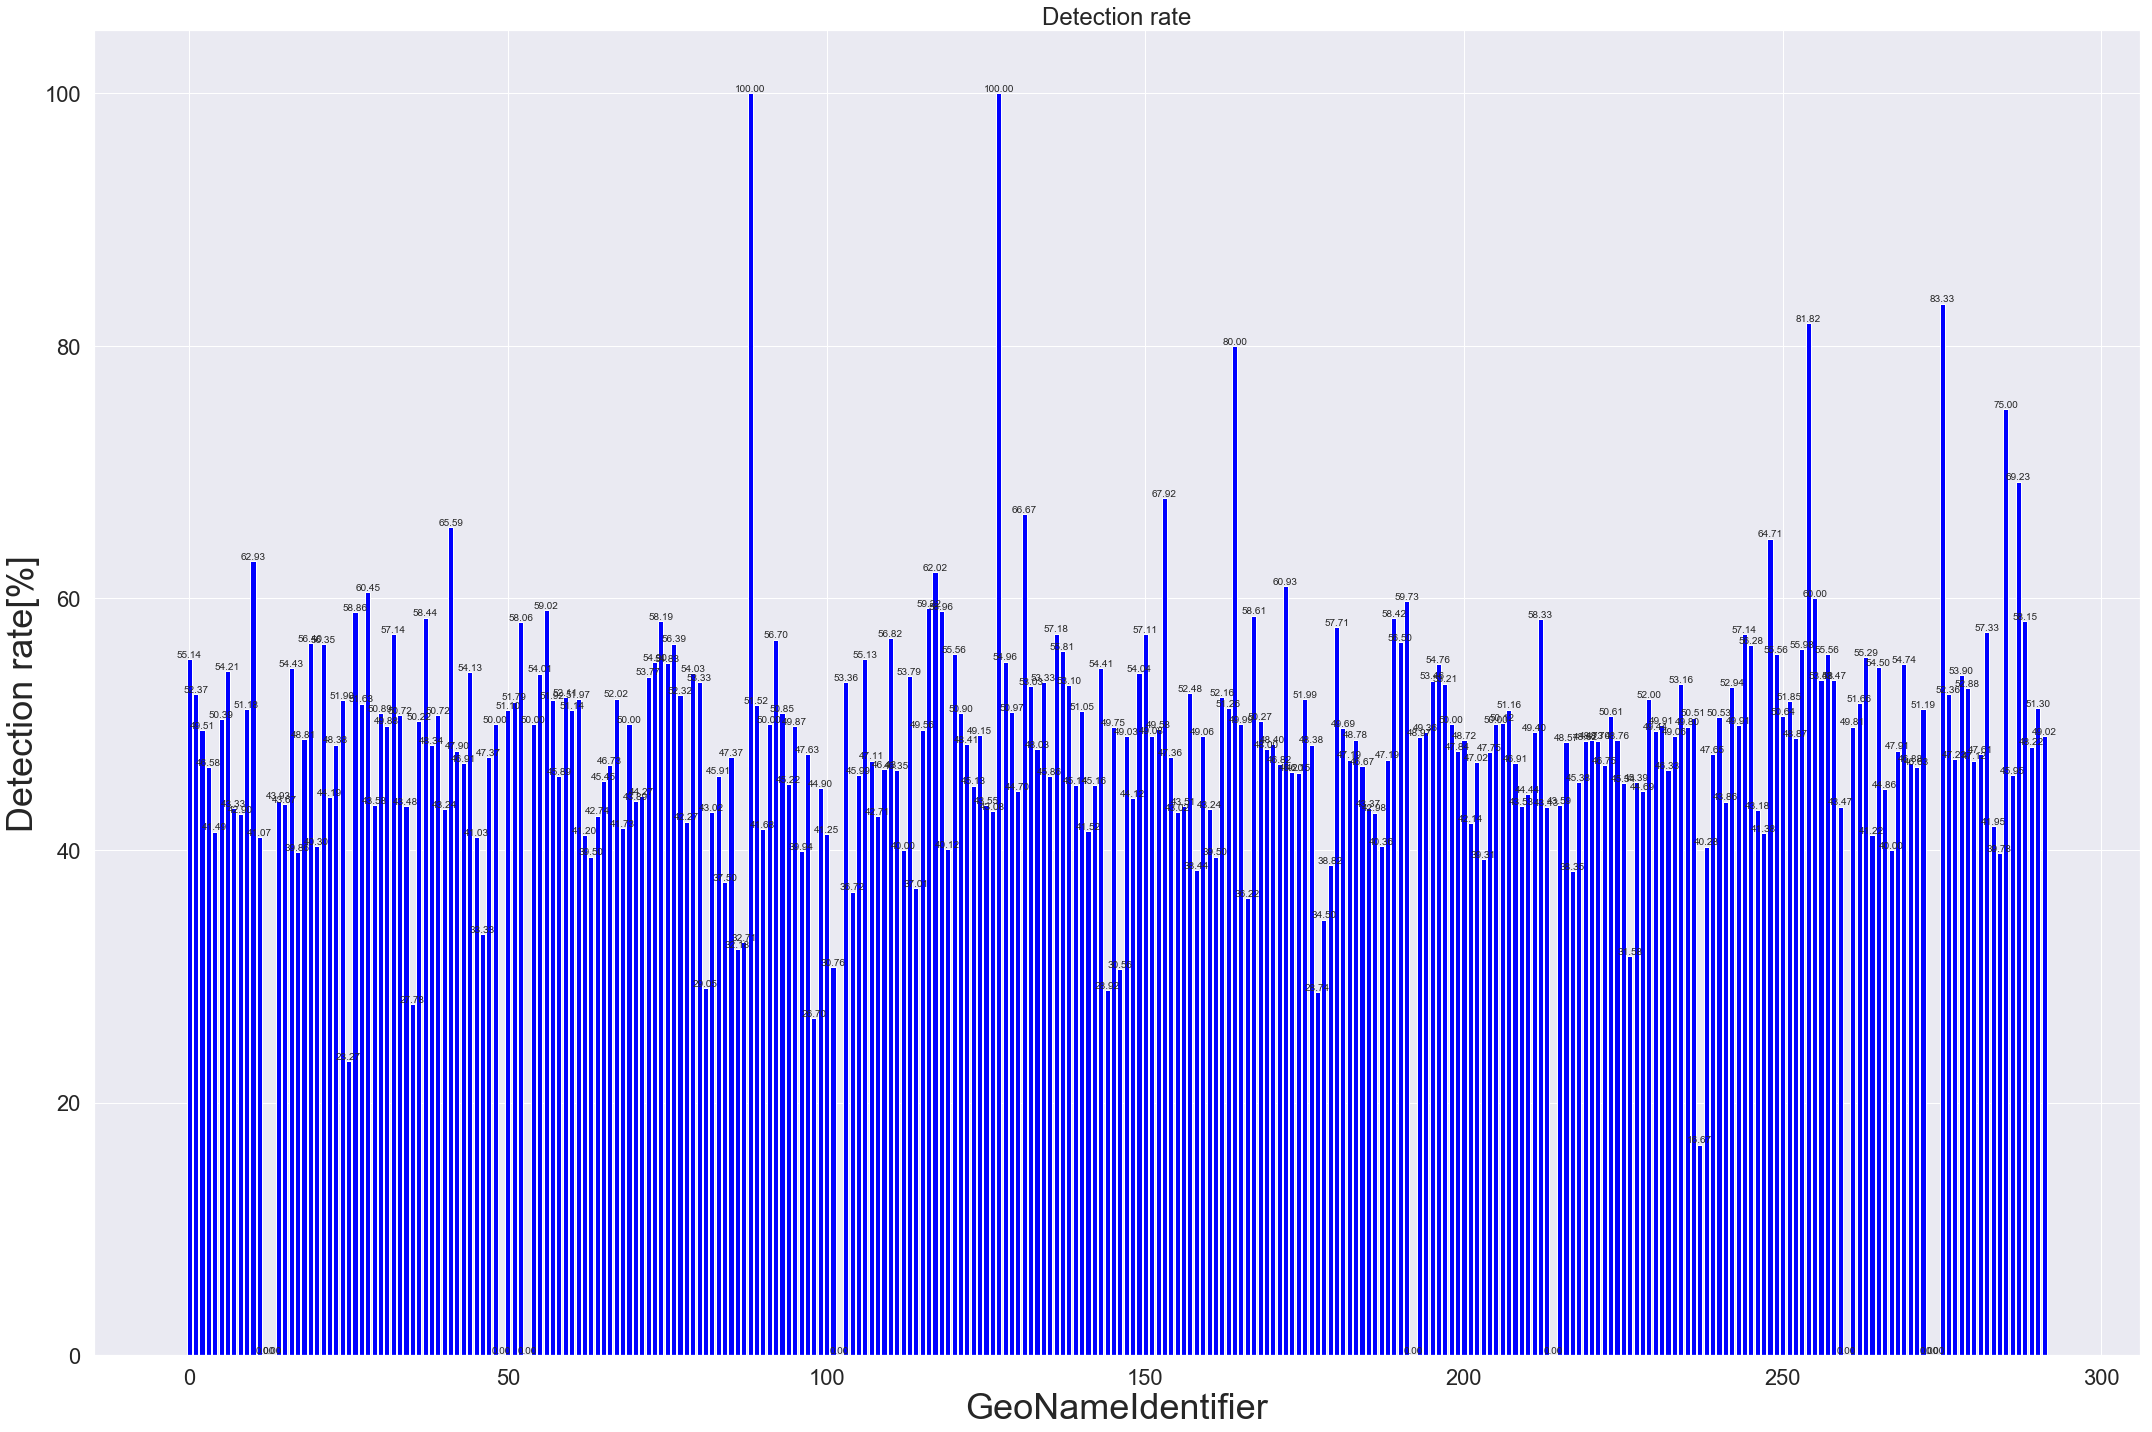

In [83]:
# 視覚化
plot_country_detection_rate(train, column)

In [32]:
# dataのGeoNameIdentifierごとの感染率
geo_detection_rate = train.groupby(column, as_index=False).mean()
geo_detection_rate["HasDetections"] = geo_detection_rate["HasDetections"] * 100 
geo = geo_detection_rate["HasDetections"].sort_values(ascending=False)

In [48]:
# sample数上位10の感染率
big_sample_column=[272,206,51,85,235,33,162,271,262,122]
geo[big_sample_column].sort_values()

271    46.632791
85     47.373322
122    48.406987
235    49.801482
206    50.115085
33     50.721587
272    51.185727
262    51.655144
51     51.788252
162    52.156424
Name: HasDetections, dtype: float64

思ったより大きな差はでなかった.データ自体恣意的に作られているためだろう

In [78]:
train_162 = train[train['GeoNameIdentifier']==162][['Census_OSArchitecture',"HasDetections"]]
train_162.isnull().sum()

Census_OSArchitecture    0
HasDetections            0
dtype: int64

In [ ]:
# 視覚化する関数
def plot_country_detection_rate(data_source, col_name, flag_rename_x_label=False):
    """
   X軸を指定された列として検出率を棒グラフでプロット

   parameter
   --------------
   data_source : Pandas dataframe
   col_name : string
   flag_rename_x_label : bool

   return
   --------------
   None
   """
    #ラベル毎に返済率を算出
    geo_detection_rate = data_source.groupby(col_name, as_index=False).mean()
    geo_detection_rate["HasDetections"] = geo_detection_rate["HasDetections"] * 100 

    
    #Bar plot
    plt.figure(figsize=(30,20))
    plt.bar(geo_detection_rate.index, geo_detection_rate["HasDetections"], color="Blue")
    plt.xlabel(col_name, fontsize=36)
    plt.ylabel("Detection rate[%]", fontsize=36)
    plt.title("Detection rate")
    plt.tight_layout()
    #グラフ上に数値表示
    for x, y in zip(geo_detection_rate.index, geo_detection_rate["HasDetections"]):
        plt.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
        if flag_rename_x_label == True:
            plt.xticks(geo_detection_rate.index, geo_detection_rate[col_name]) #x軸を実際のデータラベルへ置き換え
    plt.show()

In [84]:
# 271 と162を比較する
conpare_column = 'Census_OSArchitecture'

In [95]:
train_271

,Census_OSArchitecture,HasDetections
29807,amd64,0
95187,amd64,0
103057,amd64,1
123326,amd64,1
126483,amd64,0
134838,amd64,0
143153,amd64,1
155258,amd64,0
164368,amd64,1
206396,amd64,1


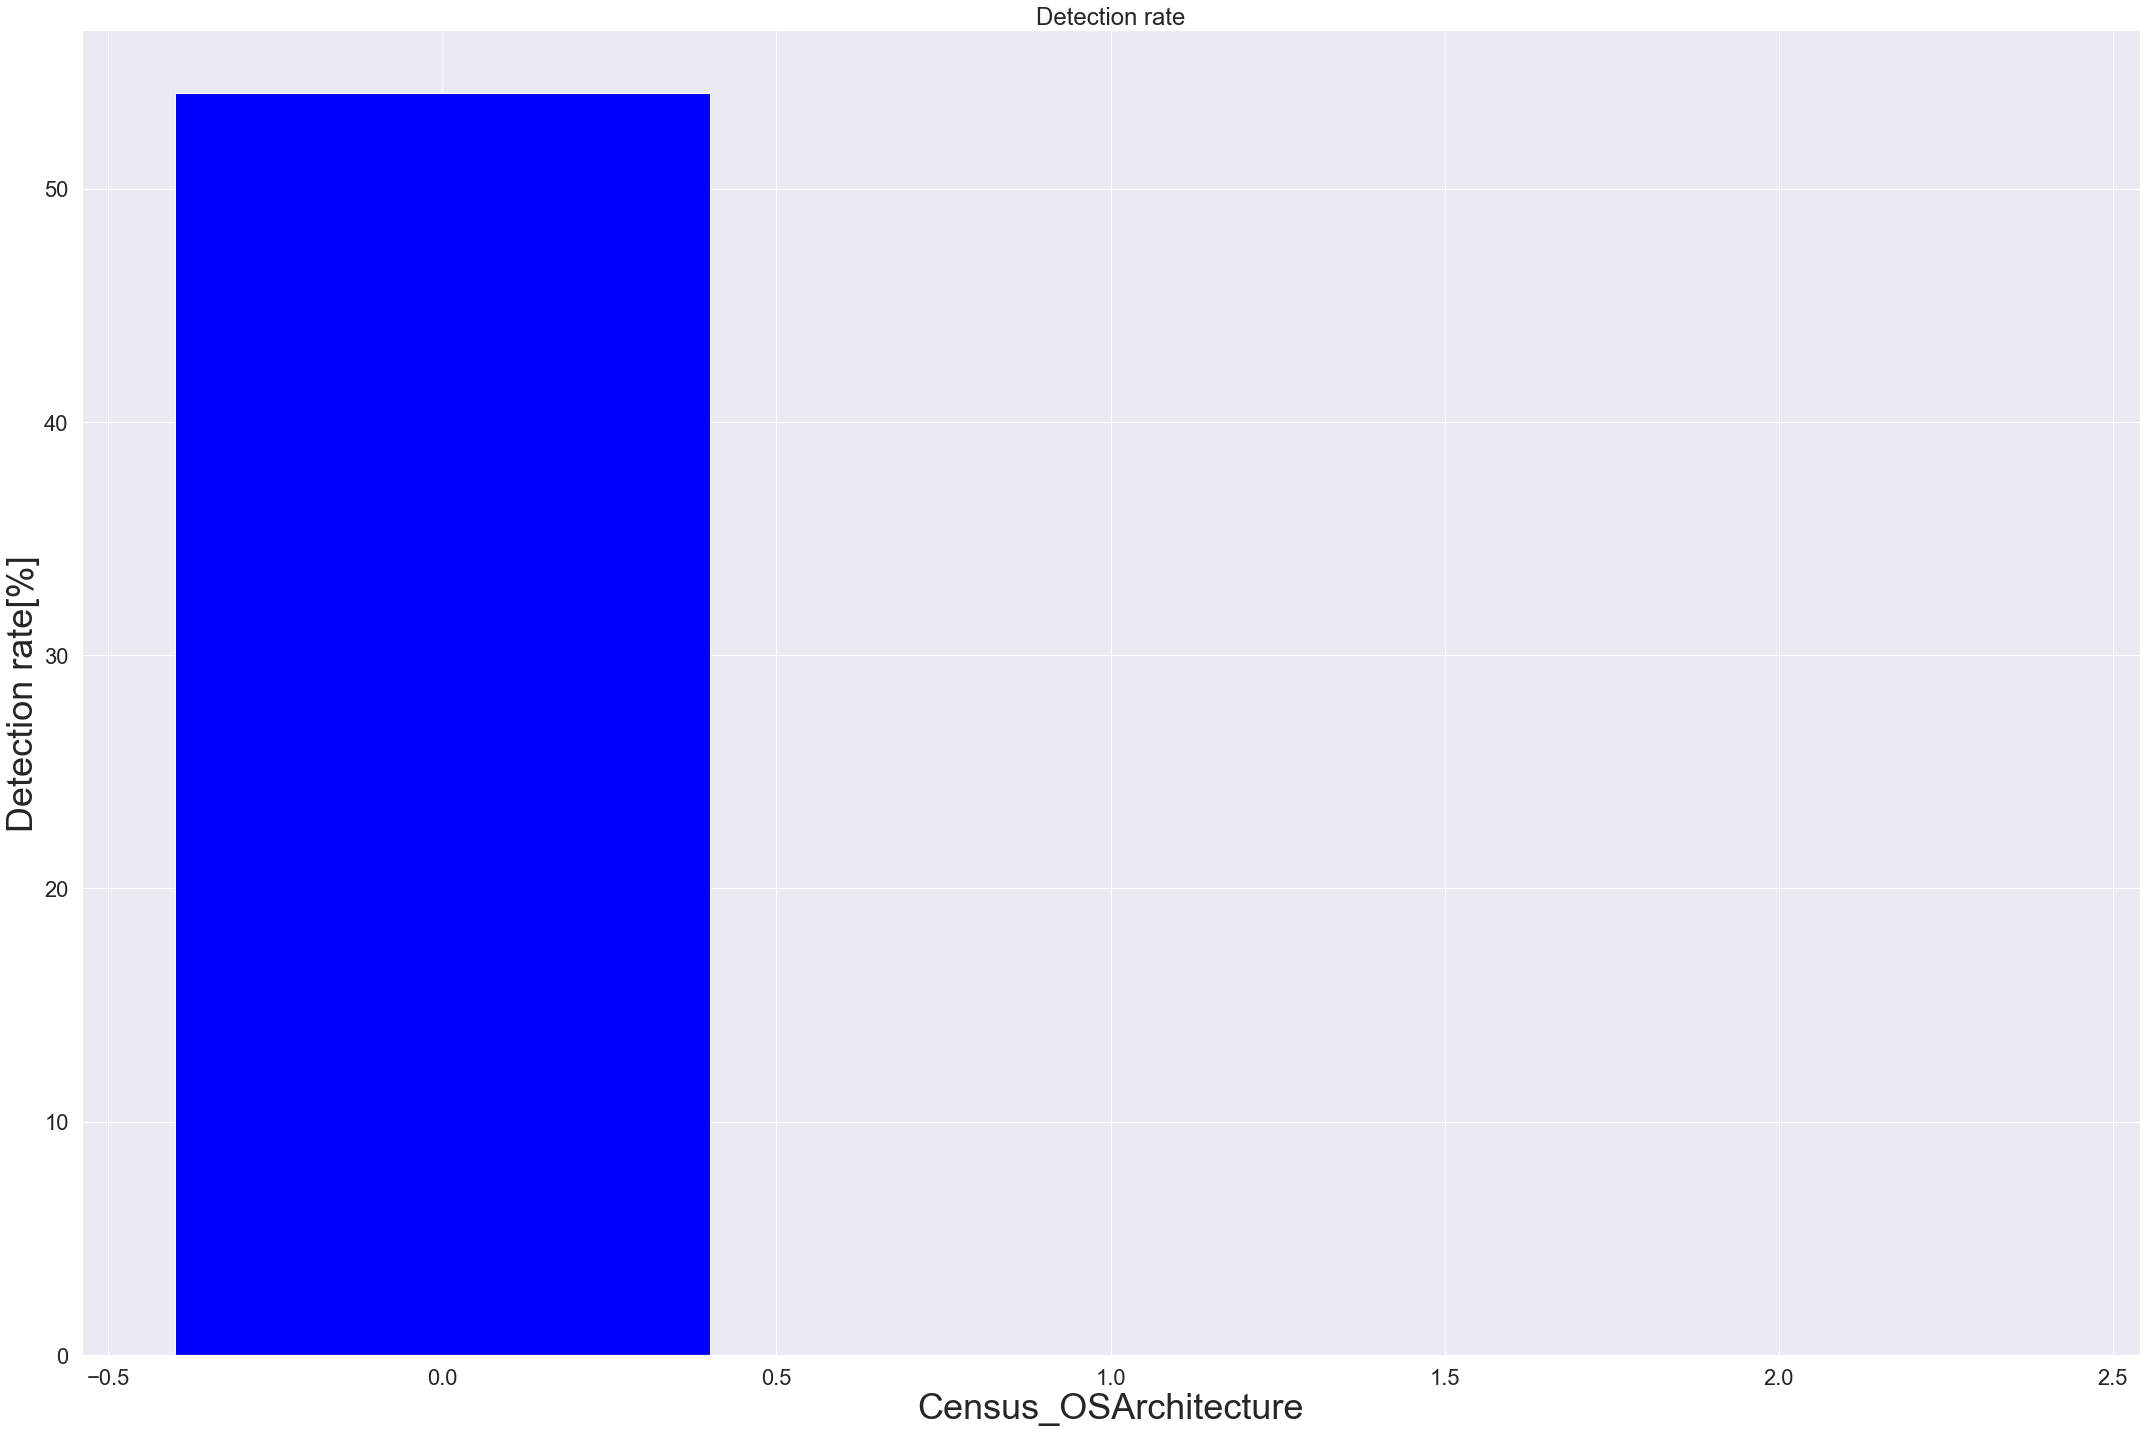

In [93]:
# 162
train_162 = train[train['GeoNameIdentifier']==162][['Census_OSArchitecture',"HasDetections"]]
train_162.isnull().sum()
geo_detection_rate = train_162.groupby(conpare_column, as_index=False).mean()
geo_detection_rate["HasDetections"] = geo_detection_rate["HasDetections"] * 100 
#Bar plot
plt.figure(figsize=(30,20))
plt.bar(geo_detection_rate.index, geo_detection_rate["HasDetections"], color="Blue")
plt.xlabel(conpare_column, fontsize=36)
plt.ylabel("Detection rate[%]", fontsize=36)
plt.title("Detection rate")
plt.tight_layout()


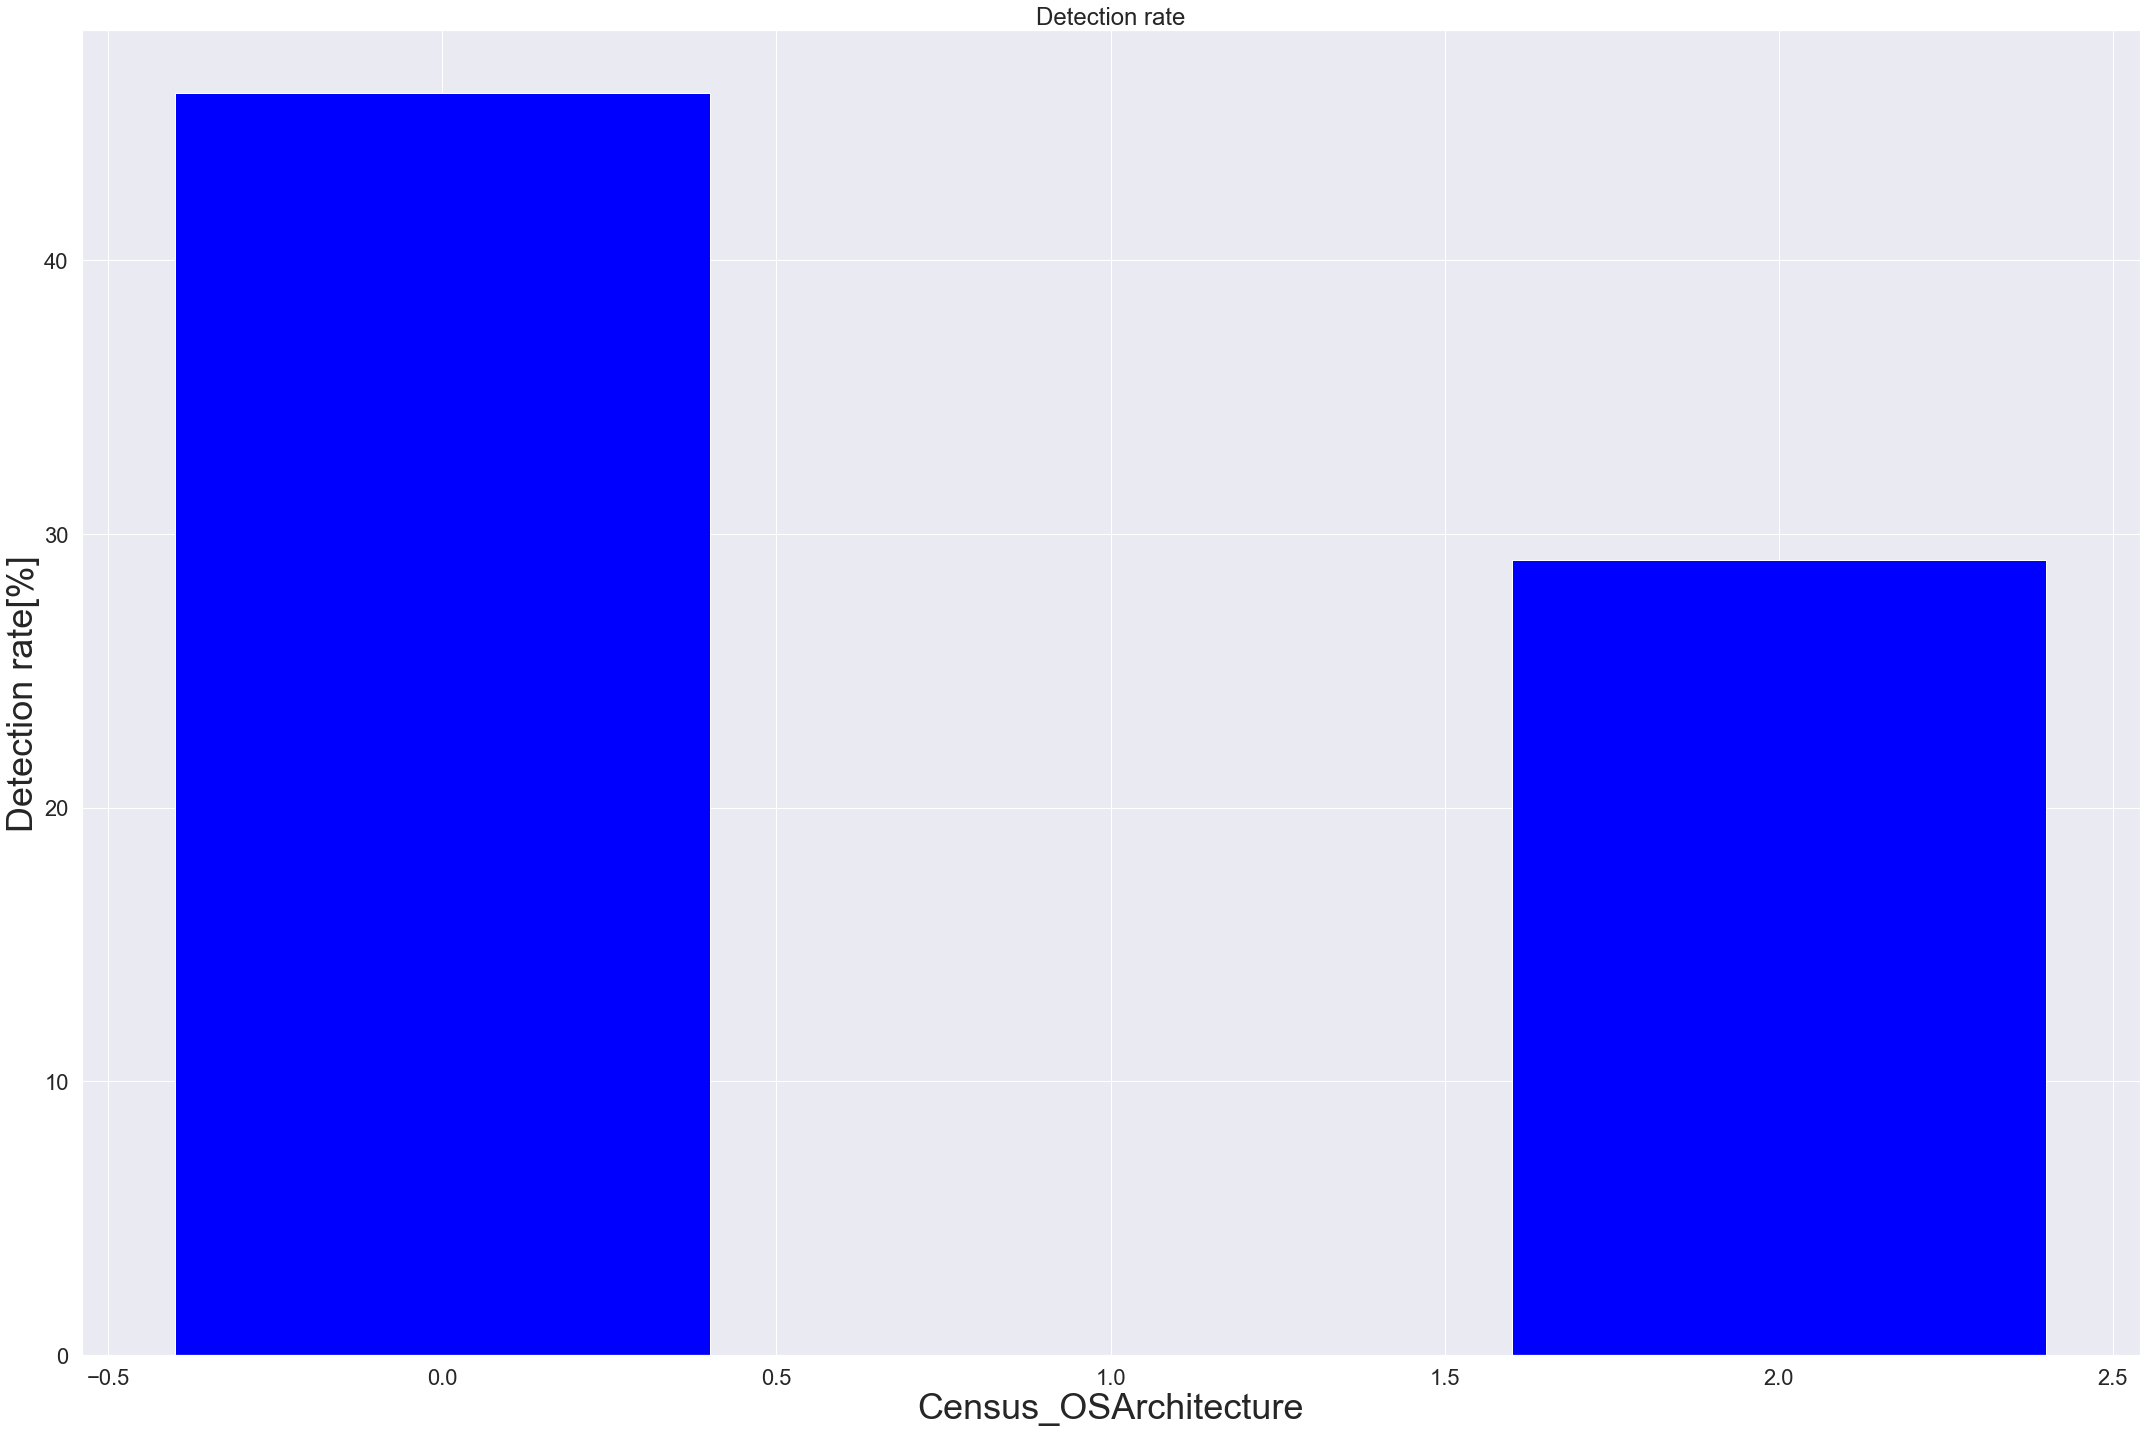

In [92]:
# 271
train_271 = train[train['GeoNameIdentifier']==271][['Census_OSArchitecture',"HasDetections"]]
train_271.isnull().sum()
geo_detection_rate_2 = train_271.groupby(conpare_column, as_index=False).mean()
geo_detection_rate_2["HasDetections"] = geo_detection_rate_2["HasDetections"] * 100 
#Bar plot
plt.figure(figsize=(30,20))
plt.bar(geo_detection_rate_2.index, geo_detection_rate_2["HasDetections"], color="Blue")
plt.xlabel(conpare_column, fontsize=36)
plt.ylabel("Detection rate[%]", fontsize=36)
plt.title("Detection rate")
plt.tight_layout()

感染率の高い国は64bitのみで低い国は32bitも使っているようだ